# Generating WorldMap and Video

# CSV Writer
import csv
import os

# if os.path.exists('./log.csv'):
#     os.remove('./log.csv')

if not os.path.exists('./log.csv'):
    with open('log.csv', 'w') as csvfile:
        fieldnames = ['Path', 'SteerAngle', 'Throttle', 'Brake', 'Speed', 'X_Position', 'Y_Position', 'Pitch','Yaw','Roll']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
    
with open('log.csv', 'r') as csvfile:
    sniffer = csv.Sniffer()
    has_header = sniffer.has_header(csvfile.readline())
    print(has_header)
    if not header:
        with open('log.csv', 'w') as csvfile:
#             fieldnames = ['Path;SteerAngle;Throttle;Brake;Speed;X_Position;Y_Position;Pitch;Yaw;Roll']
            fieldnames = ['Path', 'SteerAngle', 'Throttle', 'Brake', 'Speed', 'X_Position', 'Y_Position', 'Pitch','Yaw','Roll']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()

with open('log.csv', 'a') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    filewriter.writerow(['Derek', 'Software Developer'])
    filewriter.writerow(['Steve', 'Software Developer'])
    filewriter.writerow(['Paul', 'Manager'])

In [155]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
# imageio.plugins.ffmpeg.download()

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

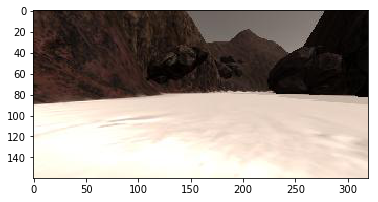

In [156]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

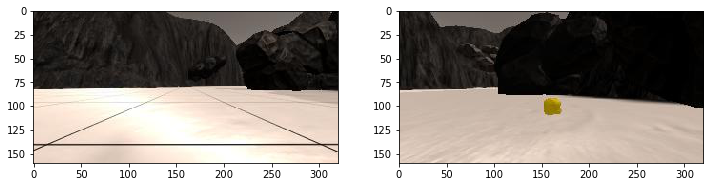

In [157]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

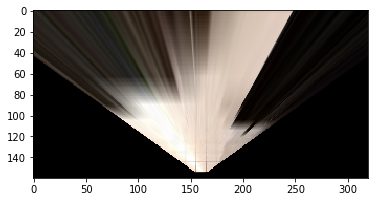

In [158]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Process stored images

In [159]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
import matplotlib.image as mpimg
import numpy
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('./log.csv', delimiter=',', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()

In [160]:
# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # 4) Convert thresholded image pixel values to rover-centric coords
    # 5) Convert rover-centric pixel values to world coords
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Using the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.

In [161]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = './mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./mapping.mp4
[MoviePy] Writing video ./mapping.mp4


100%|█████████████████████████████████████████████████████████████████████████████| 3785/3785 [00:37<00:00, 101.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./mapping.mp4 

Wall time: 37.5 s
